In [34]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [35]:
train_path = "data/train.csv"
test_path  = "data/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

TARGET = "spend_category"
ID_COL = "trip_id"

print(df_train.shape)
print(df_test.shape)

(12654, 25)
(5852, 24)


In [36]:
binary_cols = [
    "is_first_visit","intl_transport_included","accomodation_included",
    "food_included","domestic_transport_included","sightseeing_included",
    "guide_included","insurance_included"
]

categorical_cols = [
    "country","age_group","travel_companions","main_activity",
    "visit_purpose","tour_type","info_source","arrival_weather"
]

numeric_count_cols = ["num_females","num_males","mainland_stay_nights","island_stay_nights"]

REMOVING ROWS WITH NULL TRAGET VALUE


In [37]:
removed_target_nulls = df_train[TARGET].isnull().sum()
df_train = df_train[df_train[TARGET].notnull()].reset_index(drop=True)
print(df_train.shape)

(12620, 25)


34 columns removed

In [38]:
def preprocess_raw_df(df):
    df = df.copy()

    # for comma seperated values like in "has_special_requirements"
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().str.rstrip(',')

    # for binary columns
    for c in binary_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.lower()
            df[c] = df[c].replace({
                "yes": 1,
                "no": 0,
                "nan": np.nan,
                "none": np.nan,
                "null": np.nan,
                "": np.nan
            })
            df[c] = df[c].fillna(0).astype(int)

    # for numeric count fields
    for c in numeric_count_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)


    # 7-Jan ---> 7-jan
    # null/none/nan ----> np.nan
    def clean(x):
        x = str(x).strip().lower()
        if x in ["nan", "none", "null", ""]:
            return np.nan
        return x

    # clean string columns
    if "days_booked_before_trip" in df.columns:
        df["days_booked_before_trip_clean"] = df["days_booked_before_trip"].apply(clean)

    if "total_trip_days" in df.columns:
        df["total_trip_days_clean"] = df["total_trip_days"].apply(clean)

    # define ordinal mappings
    ordinal_days_booked = {
        "1-7": 1,
        "8-14": 2,
        "15-30": 3,
        "31-60": 4,
        "61-90": 5,
        "90+": 6
    }

    ordinal_total_trip = {
        "1-6": 1,
        "7-14": 2,
        "15-30": 3,
        "30+": 4
    }

    if "days_booked_before_trip_clean" in df.columns:
        df["days_booked_before_trip_ord"] = (
            df["days_booked_before_trip_clean"]
                .map(ordinal_days_booked)
        )

        # Fill NaN with mode of ordinal values
        df["days_booked_before_trip_ord"].fillna(
            df["days_booked_before_trip_ord"].mode()[0],
            inplace=True
        )

        df["days_booked_before_trip_ord"] = df["days_booked_before_trip_ord"].astype(int)
    
    # same thing for total_trip_days
    if "total_trip_days_clean" in df.columns:
        df["total_trip_days_ord"] = (
            df["total_trip_days_clean"]
                .map(ordinal_total_trip)
        )

        # Fill NaN with mode of ordinal values
        df["total_trip_days_ord"].fillna(
            df["total_trip_days_ord"].mode()[0],
            inplace=True
        )

        df["total_trip_days_ord"] = df["total_trip_days_ord"].astype(int)



    # Special requirements → binary
    if "has_special_requirements" in df.columns:
        df["has_special_req_bin"] = df["has_special_requirements"].astype(str).apply(
            lambda x: 0 if x.lower() in ["none", "", "nan"] else 1
        )

    return df

In [39]:
for c in df_train.columns:
        if df_train[c].dtype == object:
            df_train[c] = df_train[c].astype(str).str.strip().str.rstrip(',')


for c in df_test.columns:
    if df_test[c].dtype == object:
        df_test[c] = df_test[c].astype(str).str.strip().str.rstrip(',')

In [40]:
for c in binary_cols:
        if c in df_test.columns:
            df_test[c] = df_test[c].astype(str).str.strip().str.lower()
            df_test[c] = df_test[c].replace({
                "yes": 1,
                "no": 0,
                "nan": np.nan,
                "none": np.nan,
                "null": np.nan,
                "": np.nan
            })
            df_test[c] = df_test[c].fillna(0).astype(int)


for c in binary_cols:
    if c in df_train.columns:
        df_train[c] = df_train[c].astype(str).str.strip().str.lower()
        df_train[c] = df_train[c].replace({
            "yes": 1,
            "no": 0,
            "nan": np.nan,
            "none": np.nan,
            "null": np.nan,
            "": np.nan
        })
        df_train[c] = df_train[c].fillna(0).astype(int)


/tmp/ipykernel_30115/4269685273.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[c] = df_test[c].replace({
/tmp/ipykernel_30115/4269685273.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[c] = df_test[c].replace({
/tmp/ipykernel_30115/4269685273.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcas

In [41]:
for c in numeric_count_cols:
        if c in df_train.columns:
            df_train[c] = pd.to_numeric(df_train[c], errors="coerce").fillna(0).astype(int)

for c in numeric_count_cols:
        if c in df_test.columns:
            df_test[c] = pd.to_numeric(df_test[c], errors="coerce").fillna(0).astype(int)

cleaning days_booked_before and total_trip_days for train

In [42]:
def clean(x):
    x = str(x).strip().lower()
    if x in ["nan", "none", "null", ""]:
        return np.nan
    return x

# clean string columns
if "days_booked_before_trip" in df_train.columns:
    df_train["days_booked_before_trip_clean"] = df_train["days_booked_before_trip"].apply(clean)

if "total_trip_days" in df_train.columns:
    df_train["total_trip_days_clean"] = df_train["total_trip_days"].apply(clean)

# define ordinal mappings
ordinal_days_booked = {
    "1-7": 1,
    "8-14": 2,
    "15-30": 3,
    "31-60": 4,
    "61-90": 5,
    "90+": 6
}

ordinal_total_trip = {
    "1-6": 1,
    "7-14": 2,
    "15-30": 3,
    "30+": 4
}

if "days_booked_before_trip_clean" in df_train.columns:
    df_train["days_booked_before_trip_ord"] = (
        df_train["days_booked_before_trip_clean"]
            .map(ordinal_days_booked)
    )

    # Fill NaN with mode of ordinal values
    df_train["days_booked_before_trip_ord"].fillna(
        df_train["days_booked_before_trip_ord"].mode()[0],
        inplace=True
    )

    df_train["days_booked_before_trip_ord"] = df_train["days_booked_before_trip_ord"].astype(int)

# same thing for total_trip_days
if "total_trip_days_clean" in df_train.columns:
    df_train["total_trip_days_ord"] = (
        df_train["total_trip_days_clean"]
            .map(ordinal_total_trip)
    )

    # Fill NaN with mode of ordinal values
    df_train["total_trip_days_ord"].fillna(
        df_train["total_trip_days_ord"].mode()[0],
        inplace=True
    )

    df_train["total_trip_days_ord"] = df_train["total_trip_days_ord"].astype(int)

/tmp/ipykernel_30115/3990192100.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["days_booked_before_trip_ord"].fillna(
/tmp/ipykernel_30115/3990192100.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Same for test

In [43]:


# clean string columns
if "days_booked_before_trip" in df_test.columns:
    df_test["days_booked_before_trip_clean"] = df_test["days_booked_before_trip"].apply(clean)

if "total_trip_days" in df_test.columns:
    df_test["total_trip_days_clean"] = df_test["total_trip_days"].apply(clean)



if "days_booked_before_trip_clean" in df_test.columns:
    df_test["days_booked_before_trip_ord"] = (
        df_test["days_booked_before_trip_clean"]
            .map(ordinal_days_booked)
    )

    # Fill NaN with mode of ordinal values
    df_test["days_booked_before_trip_ord"].fillna(
        df_test["days_booked_before_trip_ord"].mode()[0],
        inplace=True
    )

    df_test["days_booked_before_trip_ord"] = df_test["days_booked_before_trip_ord"].astype(int)

# same thing for total_trip_days
if "total_trip_days_clean" in df_test.columns:
    df_test["total_trip_days_ord"] = (
        df_test["total_trip_days_clean"]
            .map(ordinal_total_trip)
    )

    # Fill NaN with mode of ordinal values
    df_test["total_trip_days_ord"].fillna(
        df_test["total_trip_days_ord"].mode()[0],
        inplace=True
    )

    df_test["total_trip_days_ord"] = df_test["total_trip_days_ord"].astype(int)

/tmp/ipykernel_30115/1836473627.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["days_booked_before_trip_ord"].fillna(
/tmp/ipykernel_30115/1836473627.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [44]:
if "has_special_requirements" in df_train.columns:
    df_train["has_special_req_bin"] = df_train["has_special_requirements"].astype(str).apply(
        lambda x: 0 if x.lower() in ["none", "", "nan"] else 1
    )

if "has_special_requirements" in df_test.columns:
    df_test["has_special_req_bin"] = df_test["has_special_requirements"].astype(str).apply(
        lambda x: 0 if x.lower() in ["none", "", "nan"] else 1
    )

In [45]:
print(df_train.shape)
print(df_test.shape)

(12620, 30)
(5852, 29)


In [46]:
for c in categorical_cols:
    if c in df_train.columns:
        mode = df_train[c].mode()[0]
        df_train[c] = df_train[c].fillna(mode)
        df_test[c] = df_test[c].fillna(mode)

Removing outliers for train only

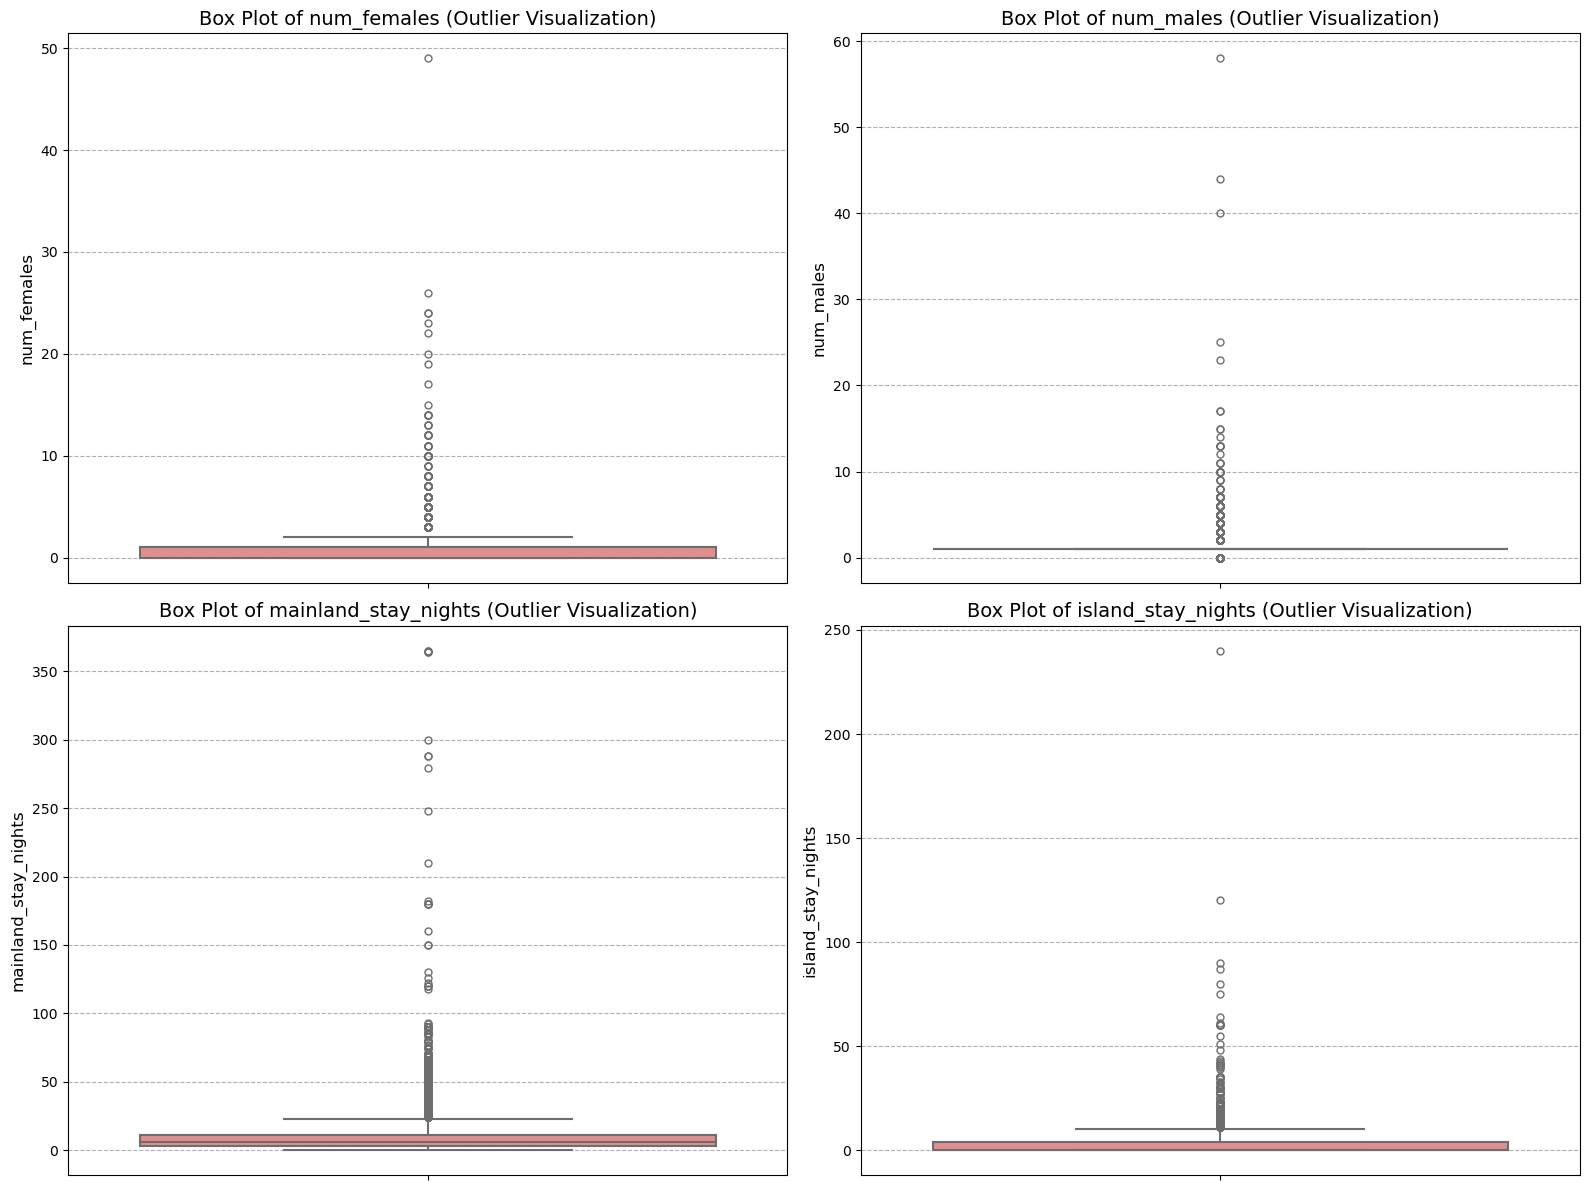

In [47]:

import matplotlib.pyplot as plt
import seaborn as sns




# columns for outlier inspection
outlier_cols = [
    "num_females",
    "num_males",
    "mainland_stay_nights",
    "island_stay_nights",
]


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Generate a Box Plot for each column, which is ideal for outlier visualization
for i, col in enumerate(outlier_cols):
    ax = axes[i]
    data_to_plot = df_train[col].dropna()
    
    # Using vertical box plots (y=data)
    sns.boxplot(y=data_to_plot, ax=ax, color='lightcoral', fliersize=5, linewidth=1.5)

    ax.set_title(f'Box Plot of {col} (Outlier Visualization)', fontsize=14)
    ax.set_ylabel(col, fontsize=12)
    ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('outlier_inspection_boxplots.png')

In [48]:
clean_df = df_train.copy()
initial_rows = len(clean_df)

outlier_info = {}


# num_females ≤ 15 
before = len(clean_df)
clean_df = clean_df[clean_df["num_females"] <= 15]
after = len(clean_df)
outlier_info["num_females"] = before - after

# num_males ≤ 15
before = len(clean_df)
clean_df = clean_df[clean_df["num_males"] <= 15]
after_rule1 = len(clean_df)
removed_rule1 = before - after_rule1
before_rule2 = len(clean_df)

# Save results
outlier_info["num_males_threshold"] = removed_rule1



# mainland_stay_nights ≤ 100 
before = len(clean_df)
clean_df = clean_df[clean_df["mainland_stay_nights"] <= 100]
after = len(clean_df)
outlier_info["mainland_stay_nights"] = before - after

#  island_stay_nights ≤ 60 
before = len(clean_df)
clean_df = clean_df[clean_df["island_stay_nights"] <= 60]
after = len(clean_df)
outlier_info["island_stay_nights"] = before - after

final_rows = len(clean_df)

for col, removed in outlier_info.items():
    print(f"{col}: removed {removed} rows")

print("---------------------------------------------")
print(f"Total rows removed: {initial_rows - final_rows}")
print(f"Final Training Shape after Outlier Removal: {clean_df.shape}")
print("Test Shape (unchanged):", df_test.shape)

num_females: removed 9 rows
num_males_threshold: removed 5 rows
mainland_stay_nights: removed 25 rows
island_stay_nights: removed 8 rows
---------------------------------------------
Total rows removed: 47
Final Training Shape after Outlier Removal: (12573, 30)
Test Shape (unchanged): (5852, 29)


In [49]:
numeric_features = [
    "num_females",
    "num_males",
    "mainland_stay_nights",
    "island_stay_nights",
    "days_booked_before_trip_ord",
    "total_trip_days_ord"
]

binary_features = binary_cols + ["has_special_req_bin"]

categorical_features = categorical_cols

all_features = numeric_features + binary_features + categorical_features

clean_df = clean_df[all_features + [TARGET]]
test_df_final = df_test[all_features]

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# APPLY SCALING AND ONE-HOT ENCODING


preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # Use sparse_output=False to get a dense numpy array output for easier DataFrame conversion
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("bin", "passthrough", binary_features) # Binary features are already 0/1, just pass them through
    ],
    remainder='drop' # Drop any columns not explicitly listed above
)

# 2. Fit and Transform Training Data
X_train = clean_df[all_features]
y_train = clean_df[TARGET] 

X_train_transformed = preprocess.fit_transform(X_train)
# Get the names of the new encoded columns
feature_names = preprocess.get_feature_names_out()
train_final = pd.DataFrame(X_train_transformed, columns=feature_names)
train_final[TARGET] = y_train.values # Add back the target column

# 3. Transform Test Data (Use .transform() ONLY on test data)
X_test = df_test[all_features]
X_test_transformed = preprocess.transform(X_test)
test_final = pd.DataFrame(X_test_transformed, columns=feature_names)

train_final.to_csv("train_fully_processed.csv", index=False)
test_final.to_csv("test_fully_processed.csv", index=False)

print("\n--- Final Preprocessing Complete: Files Saved ---")
print(f"train_fully_processed.csv saved with shape: {train_final.shape}")
print(f"test_fully_processed.csv saved with shape: {test_final.shape}")


--- Final Preprocessing Complete: Files Saved ---
train_fully_processed.csv saved with shape: (12573, 189)
test_fully_processed.csv saved with shape: (5852, 188)
